In [ ]:
#| default_exp modified_efficient_importance_sampling
import jax
jax.config.update("jax_enable_x64", True)

# Modified Efficient Importance Sampling
> See also the corresponding [section in my thesis](https://stefanheyder.github.io/dissertation/thesis.pdf#nameddest=subsection.3.6.1)



Modified efficient importance sampling is used to improve on the [Laplace approximation](./30_laplace_approximation.ipynb). The goal is to minimize the variance of log-weights in importance sampling [@Richard2007Efficient,@Koopman2019Modified]. If the importance sampling model is a Gaussian one where observations are conditionally independent across time and space, its iterations reduce to a least squares problem which can be solved efficiently.

$$
\int \left(\log p (y | x) - \log g(y|x) - \lambda \right)^2 \log p(x|y) \mathrm d x
$$
where $\lambda = \mathbf E \left(\log p(y|x) - \log g(z|x)| Y = y\right)$. This is approximated by an importance sampling version 

$$
\sum_{i = 1}^N \left(\log p(y|X^i) - \log g(z|X^i) - \lambda\right) w(X^i).
$$

Using gaussian proposals $g$ we have for signals $S_t = B_t X_t$

$$
\begin{align*}
\log g(z_{t}|s_{t}) &= -\frac{1}{2} (z_{t} - s_{t})^T\Omega^{-1}_{t}(z_{t} - s_{t}) - \frac{p}{2} \log (2\pi) - \frac{1}{2} \log \det \Omega_{t}.
\end{align*}
$$
where $\Omega_t = \operatorname{diag} \left( \omega_{t,1}, \dots, \omega_{t,p}\right)$.



Due to the large dimension of the problem we solve it for each $t$ separately

$$
\begin{align*}
\sum_{i = 1}^N(\log p(y_t|s_t^{i}) - \log g(z_{t}| s_t^{i}) - \lambda_{t})^2 w(s_t^i) &= \sum_{i = 1}^N\left(\log p(y_t|s_t^{i}) +\frac{1}{2} (z_{t} - s_{t}^{i})^T\Omega^{-1}_{t}(z_{t} - s_{t}^{i}) + \frac{p}{2} \log (2\pi) + \frac{1}{2} \log \det \Omega_{t} - \lambda_{t}\right)^2 w(s_t^i) 
%&=  \sum_{i = 1}^{N}(\log p(y_t|s_t^{i}) - (- 2 \Omega_t ^{-1}z_t)^{T} s^{i}_t -  (s^{i}_t)^T\Omega_t^{-1}s^{i}_t - \lambda_t - C_t)^2w(s_t^i) \\
%&= \sum_{i = 1}^N \left(\log p(y_t|s_t^{i}) - (s^{i}_t)^{T}(- 2 \Omega_t ^{-1}z_t) + \frac{1}{2} \sum_{j = 1}^{p} (s^{i}_{t,j})^{2} \frac{1}{\omega_{t,j}} - \lambda_t - C_t \right)
\end{align*}
$$

and minimized over the unknown parameters $\left(z_t, \Omega_t, \lambda_t - C_t\right)$, which is a weighted least squares setting with "observations" $\log p(y_t|s_t)$.

To perform the estimation memory efficient, we combine the FFBS algorithm (see [00_glssm.ipynb]) with the optimization procedure, so the memory requirement of this algorithm is $\mathcal O(N)$ instead of $\mathcal O(N\cdot n)$.

<!--
At time $t$ the problem can be formulated as the following constrained linear least squares problem:

$$
\begin{align*}
    \min_{x} (y - Ax)^{T} W (y - Ax) &= x^{T}A^{T}W Ax - 2 y^{T} W Ax + y^{T}Wy= \frac{1}{2} x^{T}Qx + c^Tx + y^{T}Wy \\
    \text{subject to ~ ~ ~ ~ ~} & l \leq x \leq u
\end{align*}
$$
where
$$
\begin{align*}
    y &=  \left(\log p(y_{t}| s_{y}^{1}), \dots, \log p(y_{t}|s_{t}^N)\right)^{T} &\in \mathbf{R}^{N}\\
    A &= \left( \mathbf 1_{(N, 1)}, S, -\frac{1}{2} S^{2}  \right) &\in \mathbf{R}^{N \times (2p + 1)}\\
    S = (S_{i,j}) &= s_{t,j}^i &\in \mathbf{R}^{N \times p}\\
    x &= \left(C_{t}, \frac{z_{t}^{1}}{\omega_{t}^1}, \dots, \frac{z_{t}^p}{\omega_{t}^p}, \frac{1}{\omega_{t}^1}, \dots, \frac{1}{\omega_{t}^p}\right) &\in \mathbf{R}^{2p + 1}\\
    C_{t} &= \lambda_{t} - \frac{1}{2}\log\det \Omega_{t} - \frac{p}{2}\log(2\pi) - \frac{1}{2} z_{t}^T\Omega_{t}^{-1}z_{t} &\in \mathbf{R}\\
    W &= \operatorname{diag} \left( w(s_{t}^1), \dots, w(s_{t}^N)\right) &\in \mathbf{R}^{N\times N}\\
    Q &= 2 A^{T}W A  &\in \mathbf{R}^{(2p + 1) \times (2p + 1)}\\
    c &= - 2 A^{T}Wy &\in \mathbf{R}^{2p+1}
\end{align*}
$$
-->

In [ ]:
# | export
import jax.numpy as jnp
import jax.random as jrn
from jaxtyping import Float, Array, PRNGKeyArray
from jax import vmap, jit
from isssm.util import converged
from isssm.importance_sampling import log_weights_t, normalize_weights
from functools import partial
from jax.lax import while_loop
from isssm.kalman import kalman, simulation_smoother
from jax.lax import scan
from isssm.util import MVN_degenerate as MVN, mm_sim

from isssm.glssm import mm_sim
from isssm.typing import GLSSM, PGSSM

@jit
def optimal_parameters(signal: Float[Array, "N p"], weights: Float[Array, "N"], log_p: Float[Array, "N"]):
    ones = jnp.ones_like(weights)[:,None]
    w_inner_prod = lambda a, b: jnp.einsum('i,ij,ik->jk',weights, a, b)
    
    X_T_W_X = jnp.block([
        [w_inner_prod(ones, ones), w_inner_prod(ones, signal), w_inner_prod(ones, -.5 * signal**2)],
        [w_inner_prod(signal, ones), w_inner_prod(signal, signal), w_inner_prod(signal, -.5 * signal**2)],
        [w_inner_prod(-.5 * signal**2, ones), w_inner_prod(-.5 * signal**2, signal), w_inner_prod(-.5 * signal**2, -.5 * signal**2)]
    ])
    X_T_W_y = jnp.concatenate([
        w_inner_prod(ones, log_p[:,None]), w_inner_prod(signal, log_p[:, None]), w_inner_prod(-.5 * signal**2, log_p[:, None])
    ])
    
    beta = jnp.linalg.solve(X_T_W_X, X_T_W_y[:,0])
    return beta 

def modified_efficient_importance_sampling(
    y: Float[Array, "n+1 p"], # observations
    model: PGSSM, # model
    z_init: Float[Array, "n+1 p"], # initial z estimate
    Omega_init: Float[Array, "n+1 p p"], # initial Omega estimate
    n_iter: int, # number of iterations
    N: int, # number of samples
    key: PRNGKeyArray, # random key
    eps: Float = 1e-5, # convergence threshold
):
    z, Omega = z_init, Omega_init

    np1, p, m = model.B.shape

    key, crn_key = jrn.split(key)

    v_norm_w = vmap(normalize_weights)
    dist = model.dist
    lw_t = vmap(vmap(lambda s, y, xi, z, Omega: log_weights_t(s, y, xi, dist, z, Omega)), (0, None, None, None, None))

    def _break(val):
        i, z, Omega, z_old, Omega_old = val

        # in first iteration we don't have old values, converged is True for NaNs
        z_converged = jnp.logical_and(converged(z, z_old, eps), i > 0)
        Omega_converged = jnp.logical_and(converged(Omega, Omega_old, eps), i > 0)
        iteration_limit_reached = i >= n_iter

        return jnp.logical_or(
            jnp.logical_and(z_converged, Omega_converged), iteration_limit_reached
        )
    def _iteration(val):
        i, z, Omega, _, _ = val
        glssm_approx = GLSSM(model.x0, model.A, model.Sigma, model.B, Omega)
        sim_signal = simulation_smoother(glssm_approx, z, N, crn_key)

        log_weights = lw_t(sim_signal, y, model.xi, z, Omega)
        log_p = dist(sim_signal, model.xi).log_prob(y).sum(axis=-1)
        wls_estimate = vmap(optimal_parameters, (1,1,1), 0)(sim_signal, v_norm_w(log_weights), log_p)

        a = wls_estimate[:, 0]
        b = wls_estimate[:, 1 : (p + 1)]
        c = wls_estimate[:, (p + 1) :]

        z_new = b / c
        Omega_new = vmap(jnp.diag)(1 / c)

        return i + 1, z_new, Omega_new, z, Omega
    
    _keep_going = lambda *args: jnp.logical_not(_break(*args))

    n_iters, z, Omega, _, _ = while_loop(
        _keep_going, _iteration, 
        (0, z_init, Omega_init, jnp.empty_like(z_init), jnp.empty_like(Omega_init))
    )

    return z, Omega


In [ ]:
from isssm.importance_sampling import log_weights
from isssm.pgssm import  simulate_pgssm, nb_pgssm_runnning_example
from isssm.kalman import FFBS
from isssm.kalman import kalman, smoother
import jax.random as jrn
from isssm.laplace_approximation import laplace_approximation
import jax.numpy as jnp
from jax import vmap
from functools import partial
import matplotlib.pyplot as plt
from isssm.importance_sampling import ess_lw
from isssm.typing import PGSSM
from isssm.kalman import smoothed_signals
from isssm.laplace_approximation import posterior_mode
from isssm.typing import GLSSMProposal

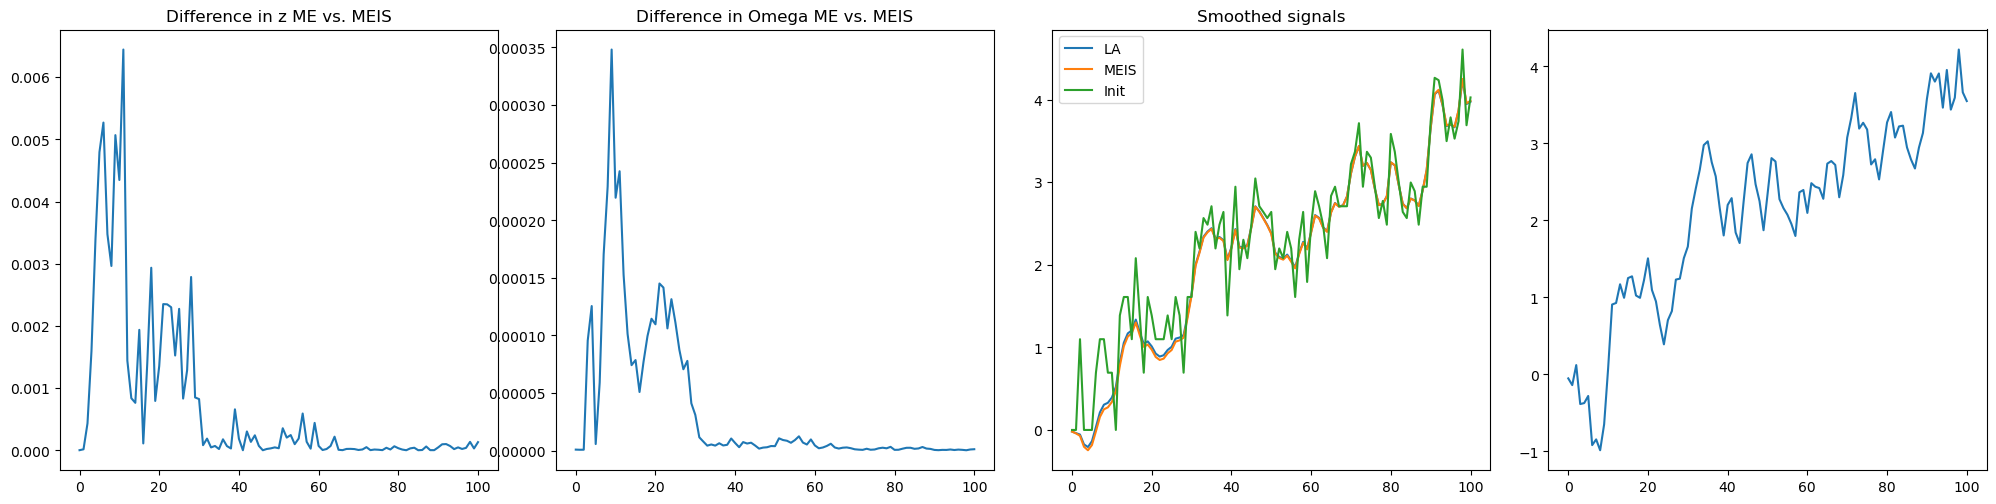

In [ ]:


model = nb_pgssm_runnning_example(s_order=0, Sigma0_seasonal=.01 * jnp.eye(0), x0_seasonal=jnp.zeros(0))
key = jrn.PRNGKey(511)
key, subkey = jrn.split(key)
N = 1
(x, ), (y,) = simulate_pgssm(model, N, subkey)
proposal_la, info_la = laplace_approximation(y, model, 10)

N = int(1e4)
key, subkey = jrn.split(key)
z_meis, Omega_meis = modified_efficient_importance_sampling(#modified_efficient_importance_sampling(
    y, model, proposal_la.z, proposal_la.Omega, 3, N, subkey
)
glssm_meis = GLSSM(model.x0, model.A, model.Sigma, model.B, Omega_meis)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.tight_layout()

z_diff = ((z_meis - proposal_la.z)**2).mean(axis=1)
axs[0].set_title("Difference in z ME vs. MEIS")
axs[0].plot(z_diff)

Omega_diff = ((Omega_meis - proposal_la.Omega)**2).mean(axis=(1,2))
axs[1].set_title("Difference in Omega ME vs. MEIS")
axs[1].plot(Omega_diff)

proposal_meis = GLSSMProposal(
    x0 =model.x0,
    A = model.A,
    Sigma = model.Sigma,
    B = model.B,
    Omega = Omega_meis,
    z = z_meis,
)
s_smooth_la = posterior_mode(proposal_la)
s_smooth_meis = posterior_mode(proposal_meis)

axs[2].set_title("Smoothed signals")
axs[2].plot(s_smooth_la, label="LA")
axs[2].plot(s_smooth_meis, label="MEIS")
axs[2].legend()

plt.show()

In [ ]:
from isssm.importance_sampling import pgssm_importance_sampling
from isssm.importance_sampling import ess_pct

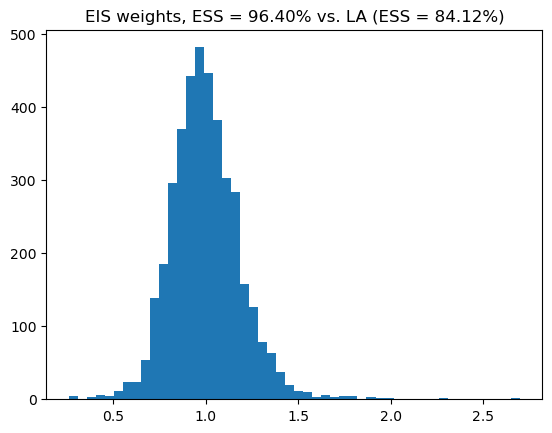

In [ ]:
N = 1000
_, lw_la = pgssm_importance_sampling(y, model, proposal_la.z, proposal_la.Omega, N, jrn.PRNGKey(423423))
samples, lw = pgssm_importance_sampling(y, model, z_meis, Omega_meis, N, jrn.PRNGKey(423423))
weights = normalize_weights(lw)
plt.title(f"EIS weights, ESS = {ess_pct(lw):.2f}% vs. LA (ESS = {ess_pct(lw_la):.2f}%)")
plt.hist(4*N*weights[None,:], bins=50)
plt.show()

EIS increases ESS of importance sampling from LA.

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()